In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Reshape, multiply
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.layers.core import Lambda
from keras.utils.vis_utils import plot_model
from tensorflow.python.framework import ops
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten,MaxPooling3D

import keras.backend as K
from keras import optimizers
import random
import sys
import cv2
import os
from skimage import io
import tensorflow as tf
import numpy as np
from keras.models import load_model
from keras import initializers
from keras.callbacks import ModelCheckpoint, EarlyStopping

import csv
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

category_num=3
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" 
config = tf.compat.v1.ConfigProto(log_device_placement=True, device_count={"CPU":4},
inter_op_parallelism_threads=4,
intra_op_parallelism_threads=2,
allow_soft_placement=True)

Number of images in train set :  2993
Number of images in test set :  643
Number of images in val set :  642


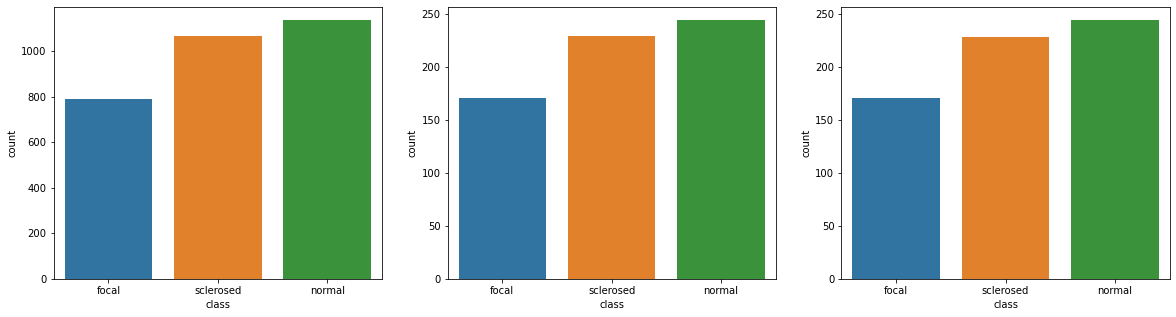

In [2]:
root_path = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/'
train_pred_test_folders = os.listdir(root_path)

train_folders = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/train/' #one more seg_train folder within
test_folders = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/test/'
val_folders = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/val/'
quantity_tr = {} 
quantity_te = {}
quantity_va = {}
for folder in os.listdir(train_folders):
    quantity_tr[folder] = len(os.listdir(train_folders+folder))

for folder in os.listdir(test_folders):
    quantity_te[folder] = len(os.listdir(test_folders+folder))

for folder in os.listdir(val_folders):
    quantity_va[folder] = len(os.listdir(val_folders+folder))

quantity_train = pd.DataFrame(list(quantity_tr.items()), index=range(0,len(quantity_tr)), columns=['class','count'])
quantity_test = pd.DataFrame(list(quantity_te.items()), index=range(0,len(quantity_te)), columns=['class','count'])
quantity_val = pd.DataFrame(list(quantity_va.items()), index=range(0,len(quantity_va)), columns=['class','count'])

figure, ax = plt.subplots(1,3,figsize=(20,5))
sns.barplot(x='class',y='count',data=quantity_train,ax=ax[0])
sns.barplot(x='class',y='count',data=quantity_test,ax=ax[1])
sns.barplot(x='class',y='count',data=quantity_val,ax=ax[2])
#sns.barplot(x='class',y='count',data=quantity_new_data,ax=ax[3])

print("Number of images in train set : ", sum(quantity_tr.values()))
print("Number of images in test set : ",sum(quantity_te.values()))
#number_of_images_in_prediction_set = len(os.listdir(seg_pred_folders))
print("Number of images in val set : ",sum(quantity_va.values()))
#print("Number of images in new dataset : ",sum(quantity_ne.values()))

plt.show()

In [3]:
category_num=3
BUFFER_SIZE = len(train_folders)
IMG_SIZE = 150

In [4]:
train_datagen = ImageDataGenerator(rescale = 1.0/IMG_SIZE)
validation_datagen = ImageDataGenerator(rescale = 1.0/IMG_SIZE)
test_datagen = ImageDataGenerator(rescale = 1.0/IMG_SIZE)

In [5]:
def train(BATCH_SIZE):
    train_generator = train_datagen.flow_from_directory(train_folders,
                                                        batch_size=BATCH_SIZE,
                                                        shuffle=BUFFER_SIZE,
                                                        class_mode='categorical',
                                                        target_size=(IMG_SIZE, IMG_SIZE))
    return train_generator

In [6]:
def validation(BATCH_SIZE):
    
    validation_generator = validation_datagen.flow_from_directory(val_folders, 
                                                                  shuffle=BUFFER_SIZE, 
                                                                  batch_size=BATCH_SIZE, 
                                                                  class_mode='categorical', 
                                                                  target_size=(IMG_SIZE, IMG_SIZE))
    return validation_generator

In [7]:
def test(BATCH_SIZE):
    test_generator = test_datagen.flow_from_directory(test_folders,
                                                      batch_size=BATCH_SIZE,
                                                      shuffle=BUFFER_SIZE,
                                                      class_mode='categorical',
                                                      target_size=(IMG_SIZE, IMG_SIZE))
    return test_generator

In [8]:
def show_few_images(number_of_examples, predict_using_model):
    figure1, ax1 = plt.subplots(number_of_examples,len(os.listdir(train_folders)), figsize=(20,4*number_of_examples))
    ax1 = ax1.reshape(-1)
    axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
    axoff_fun(ax1)
    axs = 0
    for i, folder in enumerate(os.listdir(train_folders)):
        image_ids = os.listdir(os.path.join(train_folders,folder))
        for j in [random.randrange(0, len(image_ids)) for i in range(0,number_of_examples)]:
            path = os.path.join(train_folders,folder,image_ids[j])
            display = cv2.resize(cv2.imread(path),(IMG_SIZE,IMG_SIZE))
            display = display/IMG_SIZE
            
            plt.axis('off')
            ax1[axs].imshow(display)
            title = 'True:'+folder
            if(predict_using_model):
                predicted_classname = inv_map_classes[np.argmax(predict_using_model.predict(np.array([display])))]
                title = title+'\nPredict :'+predicted_classname
            ax1[axs].set_title(title)
            axs=axs+1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


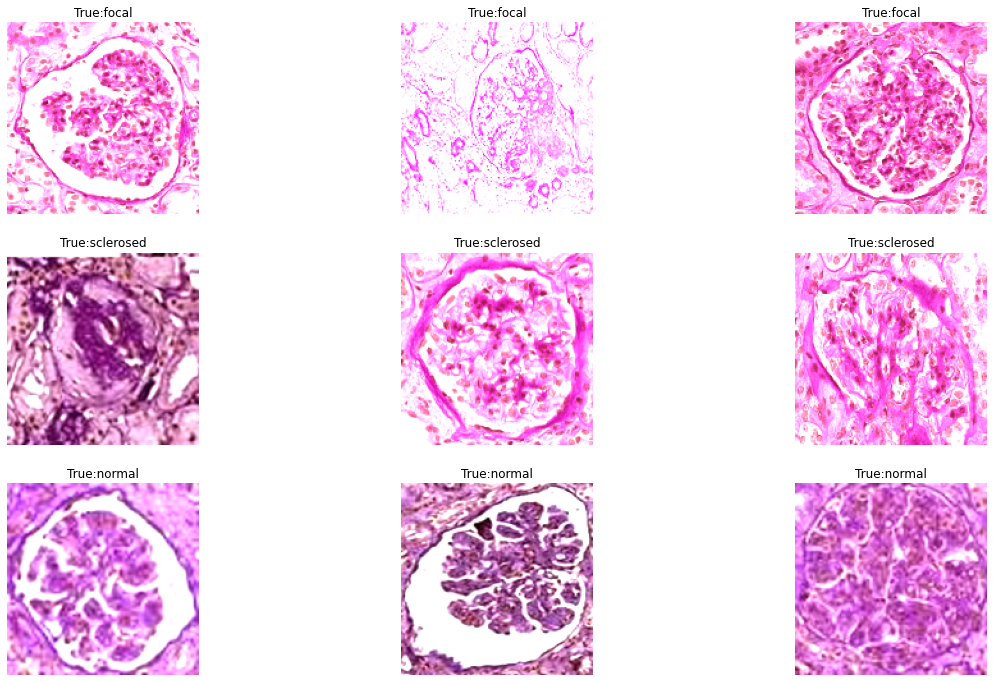

In [9]:
show_few_images(3,None)

In [10]:
strategy = tf.distribute.OneDeviceStrategy(device="/cpu:0")

In [11]:
with strategy.scope():
    model = tf.keras.applications.VGG16(pooling='avg', weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
    for layers in model.layers:
                layers.trainable=False
    last_output = model.layers[-1].output
    output = Flatten()(last_output)
    output = Dense(128, activation = 'relu')(output)
    output = Dense(3, activation = 'softmax')(output)
    model = Model(model.input, output)
    model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])

In [12]:
data_train = train(1)
data_validation = validation(1)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=5,
    workers=10,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/5
2993/2993 [==============================] - 143s 47ms/step - loss: 0.7450 - acc: 0.6650 - val_loss: 0.3671 - val_acc: 0.8551
Epoch 2/5
2993/2993 [==============================] - 144s 48ms/step - loss: 0.3506 - acc: 0.8630 - val_loss: 0.2798 - val_acc: 0.8785
Epoch 3/5
2993/2993 [==============================] - 118s 39ms/step - loss: 0.2920 - acc: 0.8751 - val_loss: 0.3627 - val_acc: 0.8474
Epoch 4/5
2993/2993 [==============================] - 144s 48ms/step - loss: 0.2801 - acc: 0.8875 - val_loss: 0.2959 - val_acc: 0.8738
Epoch 5/5
2993/2993 [==============================] - 208s 70ms/step - loss: 0.2319 - acc: 0.9090 - val_loss: 0.3145 - val_acc: 0.8738


In [13]:
data_test = test(1)
model.evaluate(data_test)

Found 643 images belonging to 3 classes.
643/643 [==============================] - 80s 124ms/step - loss: 0.3229 - acc: 0.8678


[0.3229304850101471, 0.867807149887085]

In [14]:
data_train = train(2)
data_validation = validation(2)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=5,
    workers=10,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/5
1497/1497 [==============================] - 455s 303ms/step - loss: 0.1899 - acc: 0.9235 - val_loss: 0.2525 - val_acc: 0.9034
Epoch 2/5
1497/1497 [==============================] - 390s 260ms/step - loss: 0.1772 - acc: 0.9318 - val_loss: 0.2413 - val_acc: 0.9034
Epoch 3/5
1497/1497 [==============================] - 369s 246ms/step - loss: 0.1565 - acc: 0.9425 - val_loss: 0.2365 - val_acc: 0.8988
Epoch 4/5
1497/1497 [==============================] - 357s 238ms/step - loss: 0.1547 - acc: 0.9429 - val_loss: 0.2222 - val_acc: 0.9065
Epoch 5/5
1497/1497 [==============================] - 370s 247ms/step - loss: 0.1386 - acc: 0.9412 - val_loss: 0.2895 - val_acc: 0.8785


In [15]:
data_test = test(2)
model.evaluate(data_test)

Found 643 images belonging to 3 classes.
322/322 [==============================] - 71s 220ms/step - loss: 0.2979 - acc: 0.8834


[0.2979286015033722, 0.8833592534065247]

In [16]:
data_train = train(4)
data_validation = validation(4)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=5,
    workers=10,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/5
749/749 [==============================] - 397s 530ms/step - loss: 0.1066 - acc: 0.9609 - val_loss: 0.2144 - val_acc: 0.9128
Epoch 2/5
749/749 [==============================] - 410s 547ms/step - loss: 0.1026 - acc: 0.9602 - val_loss: 0.2309 - val_acc: 0.9143
Epoch 3/5
749/749 [==============================] - 375s 500ms/step - loss: 0.0959 - acc: 0.9609 - val_loss: 0.2620 - val_acc: 0.8956
Epoch 4/5
749/749 [==============================] - 367s 489ms/step - loss: 0.0884 - acc: 0.9693 - val_loss: 0.2834 - val_acc: 0.9003
Epoch 5/5
749/749 [==============================] - 380s 507ms/step - loss: 0.0822 - acc: 0.9699 - val_loss: 0.2393 - val_acc: 0.9065


In [17]:
data_test = test(4)
model.evaluate(data_test)

Found 643 images belonging to 3 classes.
161/161 [==============================] - 68s 420ms/step - loss: 0.2354 - acc: 0.9176


[0.23537282645702362, 0.917573869228363]

In [18]:
data_train = train(8)
data_validation = validation(8)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=5,
    workers=10,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/5
375/375 [==============================] - 352s 937ms/step - loss: 0.0656 - acc: 0.9790 - val_loss: 0.2686 - val_acc: 0.9081
Epoch 2/5
375/375 [==============================] - 354s 944ms/step - loss: 0.0582 - acc: 0.9803 - val_loss: 0.2532 - val_acc: 0.9159
Epoch 3/5
375/375 [==============================] - 358s 953ms/step - loss: 0.0556 - acc: 0.9823 - val_loss: 0.3134 - val_acc: 0.8941
Epoch 4/5
375/375 [==============================] - 355s 945ms/step - loss: 0.0544 - acc: 0.9803 - val_loss: 0.2296 - val_acc: 0.9190
Epoch 5/5
375/375 [==============================] - 371s 989ms/step - loss: 0.0506 - acc: 0.9836 - val_loss: 0.2470 - val_acc: 0.9190


In [19]:
data_test = test(8)
model.evaluate(data_test)

Found 643 images belonging to 3 classes.
81/81 [==============================] - 67s 821ms/step - loss: 0.2744 - acc: 0.9051


[0.2743526101112366, 0.9051321744918823]

In [20]:
data_train = train(16)
data_validation = validation(16)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=5,
    workers=10,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/5
188/188 [==============================] - 361s 2s/step - loss: 0.0386 - acc: 0.9900 - val_loss: 0.2237 - val_acc: 0.9237
Epoch 2/5
188/188 [==============================] - 360s 2s/step - loss: 0.0344 - acc: 0.9916 - val_loss: 0.2403 - val_acc: 0.9206
Epoch 3/5
188/188 [==============================] - 356s 2s/step - loss: 0.0350 - acc: 0.9926 - val_loss: 0.2675 - val_acc: 0.9112
Epoch 4/5
188/188 [==============================] - 358s 2s/step - loss: 0.0321 - acc: 0.9930 - val_loss: 0.2492 - val_acc: 0.9159
Epoch 5/5
188/188 [==============================] - 360s 2s/step - loss: 0.0308 - acc: 0.9930 - val_loss: 0.2313 - val_acc: 0.9268


In [21]:
data_test = test(16)
model.evaluate(data_test)

Found 643 images belonging to 3 classes.
41/41 [==============================] - 63s 2s/step - loss: 0.2524 - acc: 0.9238


[0.2524018883705139, 0.923794686794281]

In [22]:
data_train = train(32)
data_validation = validation(32)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=5,
    workers=10,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/5
94/94 [==============================] - 331s 4s/step - loss: 0.0257 - acc: 0.9953 - val_loss: 0.2321 - val_acc: 0.9252
Epoch 2/5
94/94 [==============================] - 323s 3s/step - loss: 0.0240 - acc: 0.9960 - val_loss: 0.2433 - val_acc: 0.9174
Epoch 3/5
94/94 [==============================] - 328s 3s/step - loss: 0.0237 - acc: 0.9950 - val_loss: 0.2375 - val_acc: 0.9237
Epoch 4/5
94/94 [==============================] - 328s 3s/step - loss: 0.0228 - acc: 0.9960 - val_loss: 0.2371 - val_acc: 0.9237
Epoch 5/5
94/94 [==============================] - 336s 4s/step - loss: 0.0213 - acc: 0.9973 - val_loss: 0.2568 - val_acc: 0.9159


In [23]:
data_test = test(32)
model.evaluate(data_test)

Found 643 images belonging to 3 classes.
21/21 [==============================] - 60s 3s/step - loss: 0.2690 - acc: 0.9160


[0.26896509528160095, 0.9160186648368835]

In [12]:
data_train = train(64)
data_validation = validation(64)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=5,
    workers=10,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/5
47/47 [==============================] - 110s 2s/step - loss: 0.9721 - acc: 0.5090 - val_loss: 0.6742 - val_acc: 0.7399
Epoch 2/5
47/47 [==============================] - 109s 2s/step - loss: 0.6164 - acc: 0.7596 - val_loss: 0.5165 - val_acc: 0.8287
Epoch 3/5
47/47 [==============================] - 111s 2s/step - loss: 0.4994 - acc: 0.8086 - val_loss: 0.4434 - val_acc: 0.8427
Epoch 4/5
47/47 [==============================] - 114s 2s/step - loss: 0.4257 - acc: 0.8362 - val_loss: 0.3893 - val_acc: 0.8614
Epoch 5/5
47/47 [==============================] - 117s 2s/step - loss: 0.3787 - acc: 0.8718 - val_loss: 0.3636 - val_acc: 0.8754


In [13]:
data_test = test(64)
model.evaluate(data_test)

Found 643 images belonging to 3 classes.
11/11 [==============================] - 20s 2s/step - loss: 0.3633 - acc: 0.8663


[0.36333850026130676, 0.8662519454956055]

In [14]:
data_train = train(128)
data_validation = validation(128)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=5,
    workers=10,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/5
24/24 [==============================] - 101s 4s/step - loss: 0.3401 - acc: 0.8740 - val_loss: 0.3514 - val_acc: 0.8676
Epoch 2/5
24/24 [==============================] - 112s 5s/step - loss: 0.3212 - acc: 0.8821 - val_loss: 0.3373 - val_acc: 0.8816
Epoch 3/5
24/24 [==============================] - 113s 5s/step - loss: 0.3127 - acc: 0.8871 - val_loss: 0.3320 - val_acc: 0.8816
Epoch 4/5
24/24 [==============================] - 116s 5s/step - loss: 0.2987 - acc: 0.8927 - val_loss: 0.3190 - val_acc: 0.8769
Epoch 5/5
24/24 [==============================] - 120s 5s/step - loss: 0.2907 - acc: 0.8954 - val_loss: 0.3273 - val_acc: 0.8676


In [15]:
data_test = test(128)
model.evaluate(data_test)

Found 643 images belonging to 3 classes.
6/6 [==============================] - 21s 3s/step - loss: 0.3196 - acc: 0.8802


[0.31961989402770996, 0.8802488446235657]

In [16]:
data_train = train(256)
data_validation = validation(256)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=5,
    workers=10,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/5
12/12 [==============================] - 127s 11s/step - loss: 0.2794 - acc: 0.9034 - val_loss: 0.3141 - val_acc: 0.8769
Epoch 2/5
12/12 [==============================] - 127s 10s/step - loss: 0.2720 - acc: 0.9085 - val_loss: 0.3138 - val_acc: 0.8754
Epoch 3/5
12/12 [==============================] - 130s 11s/step - loss: 0.2666 - acc: 0.9041 - val_loss: 0.3059 - val_acc: 0.8769
Epoch 4/5
12/12 [==============================] - 133s 11s/step - loss: 0.2618 - acc: 0.9058 - val_loss: 0.3007 - val_acc: 0.8910
Epoch 5/5
12/12 [==============================] - 137s 11s/step - loss: 0.2574 - acc: 0.9128 - val_loss: 0.2977 - val_acc: 0.8769


In [17]:
data_test = test(256)
model.evaluate(data_test)

Found 643 images belonging to 3 classes.
3/3 [==============================] - 24s 7s/step - loss: 0.2932 - acc: 0.8896


[0.29317909479141235, 0.8895800709724426]

In [18]:
data_train = train(512)
data_validation = validation(512)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=5,
    workers=10,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/5
6/6 [==============================] - 143s 24s/step - loss: 0.2520 - acc: 0.9131 - val_loss: 0.3000 - val_acc: 0.8847
Epoch 2/5
6/6 [==============================] - 141s 24s/step - loss: 0.2502 - acc: 0.9151 - val_loss: 0.2972 - val_acc: 0.8785
Epoch 3/5
6/6 [==============================] - 143s 24s/step - loss: 0.2480 - acc: 0.9115 - val_loss: 0.2949 - val_acc: 0.8863
Epoch 4/5
6/6 [==============================] - 142s 24s/step - loss: 0.2458 - acc: 0.9138 - val_loss: 0.2967 - val_acc: 0.8847
Epoch 5/5
6/6 [==============================] - 146s 24s/step - loss: 0.2435 - acc: 0.9131 - val_loss: 0.2915 - val_acc: 0.8910


In [19]:
data_test = test(512)
model.evaluate(data_test)

Found 643 images belonging to 3 classes.
2/2 [==============================] - 26s 5s/step - loss: 0.2876 - acc: 0.8958


[0.28761953115463257, 0.8958009481430054]

In [20]:
data_train = train(1024)
data_validation = validation(1024)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=5,
    workers=10,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/5
3/3 [==============================] - 151s 54s/step - loss: 0.2428 - acc: 0.9138 - val_loss: 0.2912 - val_acc: 0.8910
Epoch 2/5
3/3 [==============================] - 148s 51s/step - loss: 0.2402 - acc: 0.9161 - val_loss: 0.2945 - val_acc: 0.8847
Epoch 3/5
3/3 [==============================] - 149s 51s/step - loss: 0.2406 - acc: 0.9175 - val_loss: 0.2934 - val_acc: 0.8847
Epoch 4/5
3/3 [==============================] - 148s 53s/step - loss: 0.2383 - acc: 0.9178 - val_loss: 0.2901 - val_acc: 0.8863
Epoch 5/5
3/3 [==============================] - 148s 51s/step - loss: 0.2381 - acc: 0.9185 - val_loss: 0.2891 - val_acc: 0.8879


In [21]:
data_test = test(1024)
model.evaluate(data_test)

Found 643 images belonging to 3 classes.
1/1 [==============================] - 27s 27s/step - loss: 0.2843 - acc: 0.8927


[0.2842680513858795, 0.8926905393600464]

In [ ]:
data_train = train(2048)
data_validation = validation(2048)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=5,
    workers=10,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/5
1/2 [==============>...............] - ETA: 25s - loss: 1.4738 - acc: 0.3534

In [ ]:
data_test = test(2048)
model.evaluate(data_test)